# Задание 2

In [1]:
import warnings
warnings.filterwarnings("ignore")

Подключаем необходимые библиотеки

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from gensim.models import Word2Vec
import pickle
import mlflow
from mlflow.models import infer_signature

Считываем данные и формируем dataset. Выводим для наглядности немного данных.

In [6]:
dataset = pd.read_csv('dataset.csv')
dataset.head(10)

,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report_0,report_1,report_2,...,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,19557662,27,40000017,6848296,0,8:44 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,659,40,128,170,258,518,81,77,79
1,18477137,93,40000029,6848296,0,9:54 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,722,40,124,162,246,504,77,75,70
2,16598616,3,40000035,6376932,1,9:07 AM,28.06.2015,Sinus tachycardia,NaN,Normal ECG except for rate,...,60 Hz notch Baseline filter,600,40,130,162,244,474,79,72,77
3,16368287,7,40000079,6214760,1,5:14 PM,15.07.2015,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,659,40,146,180,254,538,79,66,69
4,18370366,2,40000084,6632385,0,1:52 PM,27.09.2015,Sinus rhythm,NaN,NaN,...,<not specified>,659,368,29999,504,590,868,84,80,77
5,15606157,55,40000089,6632385,0,2:29 PM,29.10.2013,Sinus rhythm,NaN,NaN,...,<not specified>,822,365,29999,499,592,852,26,46,30
6,12576058,43,40000115,6852956,1,12:54 PM,23.03.2016,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,952,40,146,198,282,598,24,80,20
7,14691089,1,40000143,6551957,0,10:01 AM,10.12.2016,Sinus rhythm,rSr'(V1) - probable normal variant,Low QRS voltages in precordial leads,...,60 Hz notch Baseline filter,923,40,140,188,278,594,26,86,13
8,14144725,7,40000144,6924910,0,7:24 AM,11.12.2011,Sinus rhythm with PAC(s).,NaN,Borderline ECG,...,60 Hz notch Baseline filter,952,40,180,196,294,610,59,-17,3
9,16089780,2,40000152,6919786,0,12:35 PM,13.12.2011,Sinus rhythm,Extensive T wave changes may be due to myocard...,NaN,...,60 Hz notch Baseline filter,1000,40,156,178,274,584,8,-11,19


### Задание 1
Визуализируйте с помощью boxplot загруженные данные, опишите ваши мысли по данным.

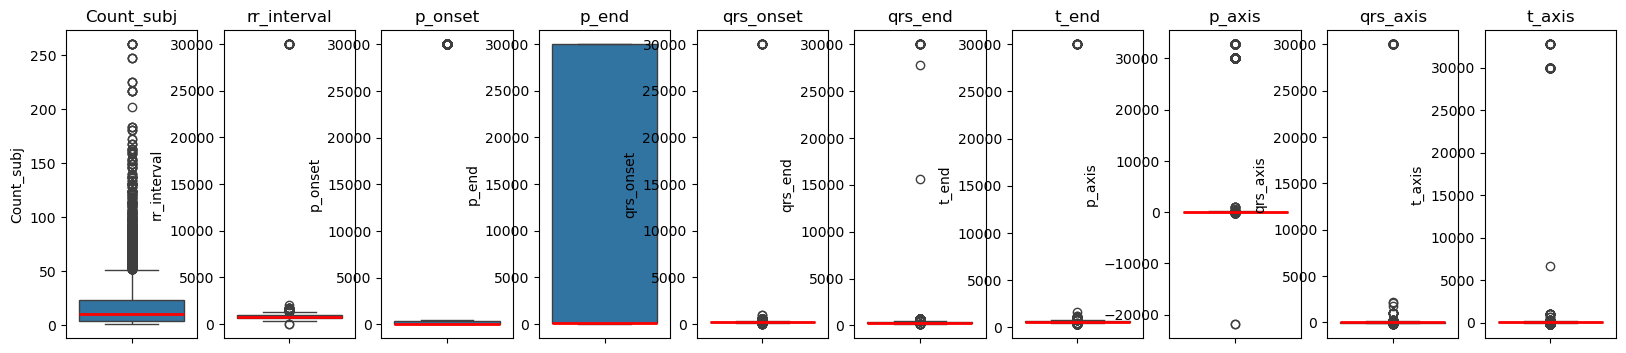

In [10]:
# Визуализация распределения числовых признаков
numerical_cols = ['Count_subj', 'rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
n = len(numerical_cols)
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    index = dataset.columns.get_loc(numerical_cols[i]) # Относительный индекс
    plt.sca(ax[i])
    col = dataset.columns[index]
    ax[i].set_title(col)
    sns.boxplot(y=dataset.iloc[:,index], data=dataset, medianprops={'color': 'r', 'linewidth': 2})

Описание данных:

- Healthy_Status:
Бинарный признак (0 или 1), где 0 может означать наличие патологии, а 1 — норму. Распределение можно проверить с помощью value_counts().
- Числовые признаки:
rr_interval: Интервал RR (время между сердечными сокращениями). Выбросы могут указывать на аритмии.
p_axis, qrs_axis, t_axis: Электрические оси сердца. Аномальные значения могут свидетельствовать о патологиях (например, отклонение оси влево/вправо).
- Категориальные признаки:
report_0, report_1, и т.д.: Текстовые описания диагнозов. Можно выделить частые термины (например, "Sinus rhythm", "Abnormal ECG").
- Выбросы:
На boxplot для rr_interval видны значительные выбросы, что может соответствовать брадикардии (слишком медленный ритм) или тахикардии (слишком быстрый ритм).
- Фильтрация и пропуски:
В данных есть пропуски (например, filtering содержит "<not specified>"). Это может повлиять на анализ.
Примеры аномалий:

Значения 29999 в столбцах p_onset, p_end и др. — вероятно, маркеры ошибок или отсутствия данных.
В Healthy_Status может быть дисбаланс классов (например, больше пациентов с патологиями).


### Задание 2
Проанализируйте данные и  проведите их предобработку (очистку, обогащение).

In [13]:
# Предобрабатываем данные словестных репортов word2vec в числовой вектор

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = dataset[(dataset[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Исправляем имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})
full_df_filtered = full_df_filtered.drop(columns = ['bandwidth', 'filtering'])

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

# Разбиваем столбец с текстовым отчетом на токены
words = [text.split() for text in full_df_filtered['report']]

# Обучаем модель Word2Vec
w2v_model = Word2Vec(words)

# Функция для получения среднего эмбеддинга строки
def get_sentence_embedding(sentence):
    words = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

# Применяем функцию ко всей колонке и переводим каждый вектор в одно число
full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

full_df_filtered.head()

,subject_id,Count_subj,study_id,cart_id,eeg_time,eeg_date,report,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,19557662,27,40000017,6848296,8:44 AM,27.06.2015,0.034966,659,40,128,170,258,518,81,77,79,0
1,18477137,93,40000029,6848296,9:54 AM,27.06.2015,0.034966,722,40,124,162,246,504,77,75,70,0
2,16598616,3,40000035,6376932,9:07 AM,28.06.2015,-0.009892,600,40,130,162,244,474,79,72,77,1
3,16368287,7,40000079,6214760,5:14 PM,15.07.2015,-0.001879,659,40,146,180,254,538,79,66,69,1
6,12576058,43,40000115,6852956,12:54 PM,23.03.2016,-0.001879,952,40,146,198,282,598,24,80,20,1


### Задание 3
Сформируйте очищенный датасет, состоящий из числовых параметров ЭКГ и классификационного признака Healthy_Status, заново построить boxplot и сравните результаты с первоначальным.

In [16]:
# make new dataset from old columns
table_data = full_df_filtered[['report','rr_interval','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status']].copy()
table_data.head()

,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,0.034966,659,128,170,258,518,81,77,79,0
1,0.034966,722,124,162,246,504,77,75,70,0
2,-0.009892,600,130,162,244,474,79,72,77,1
3,-0.001879,659,146,180,254,538,79,66,69,1
6,-0.001879,952,146,198,282,598,24,80,20,1


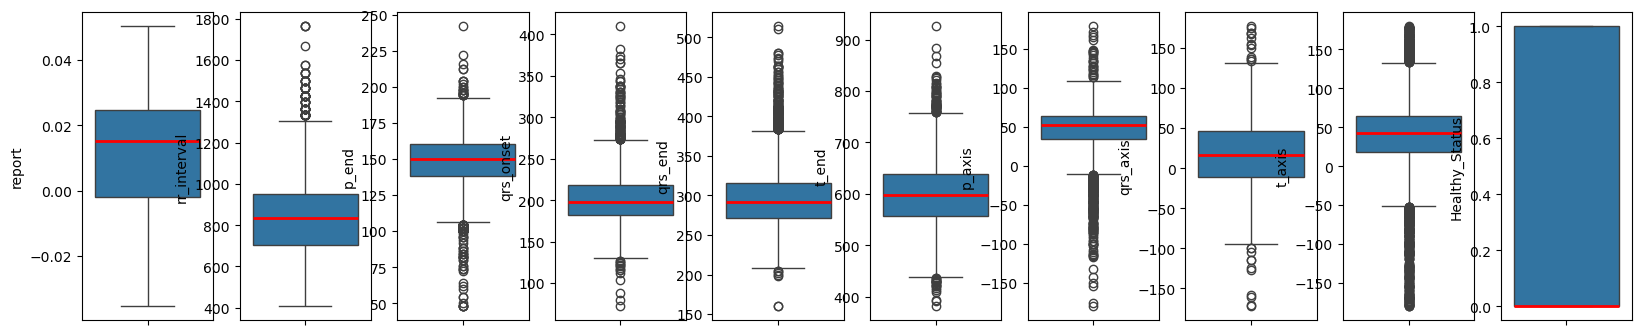

In [18]:
n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data, medianprops={"color": "r", "linewidth": 2})

### Задание 4
Проведите оценку взаимосвязи данных датасета с помощью функции heatmap.


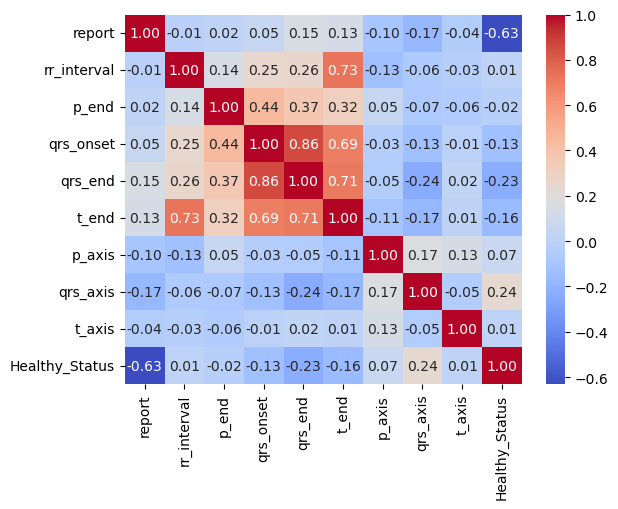

In [20]:
sns.heatmap(table_data.corr(),annot=True,fmt="0.2f",cmap="coolwarm")
plt.show()

### Задание 5
На основе таргета (целевого признака) Healthy_Status построить корреляционную матрицу с помощью pairplot.


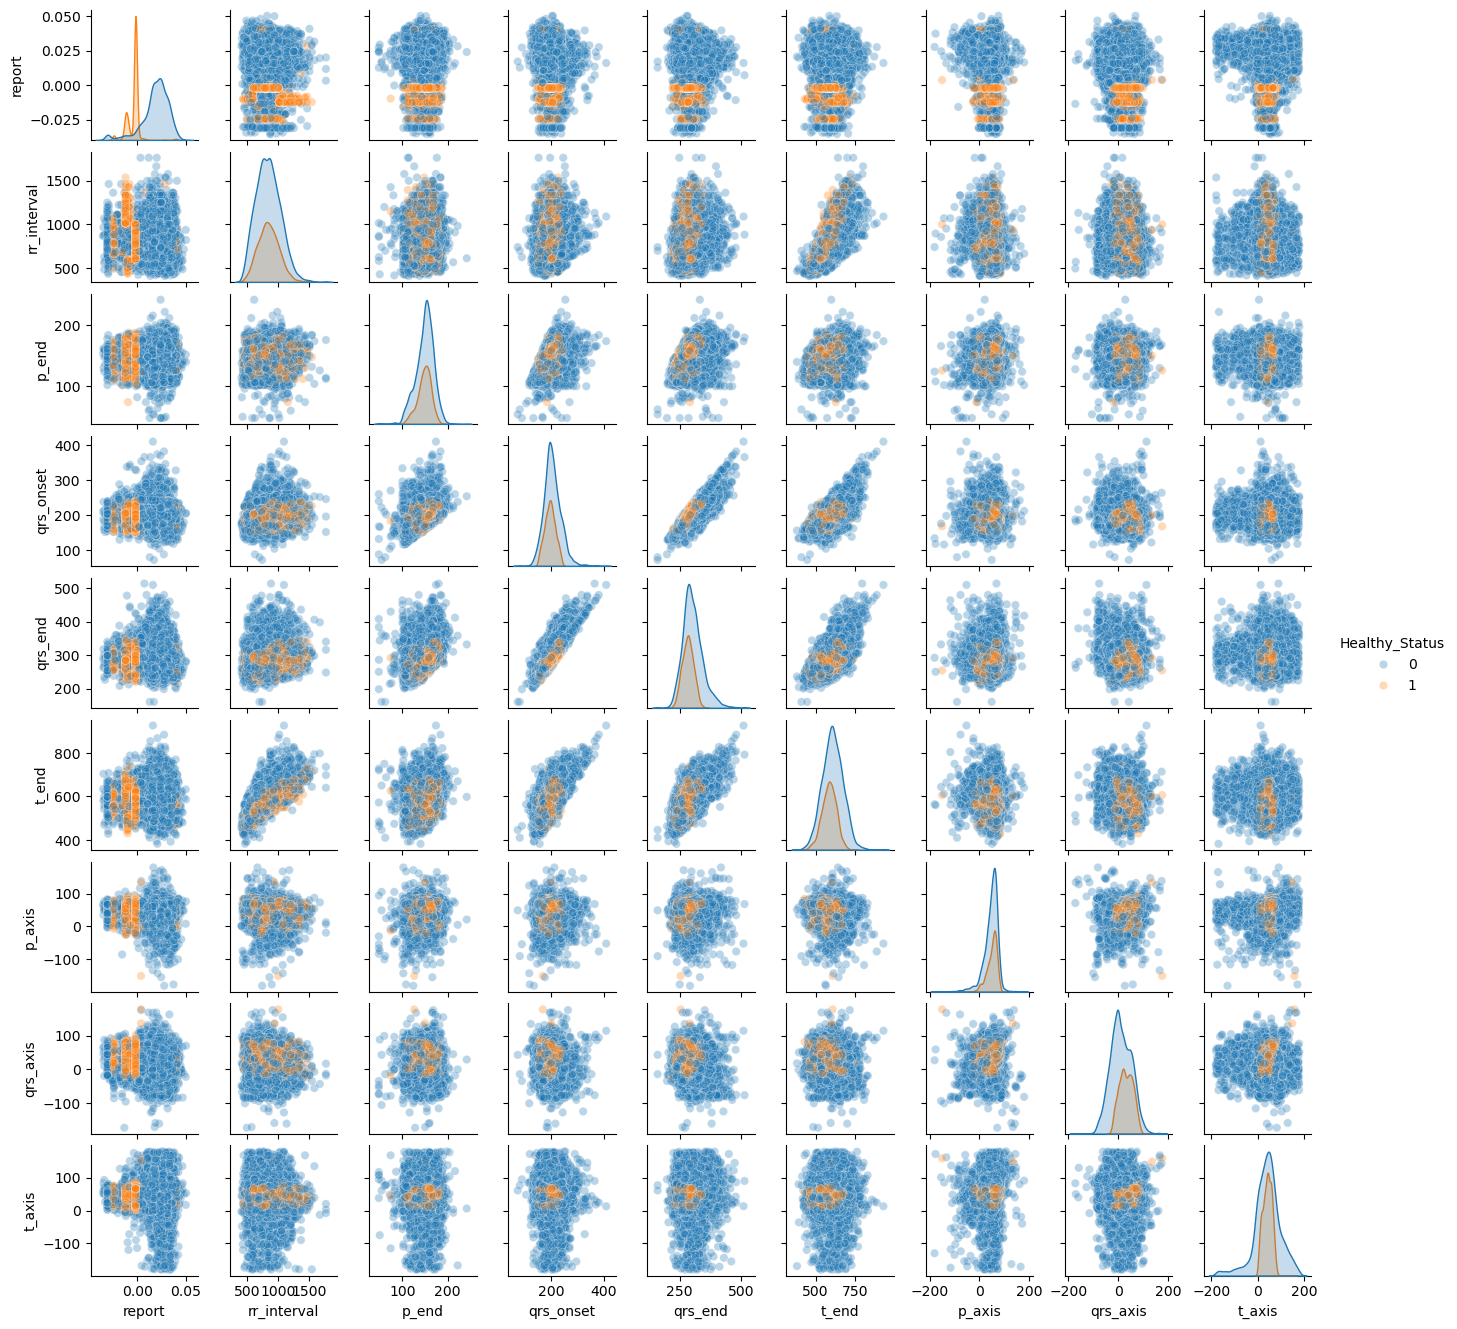

In [24]:
sns.pairplot(table_data, hue = "Healthy_Status",
             height=1.5,
             plot_kws=dict(alpha=0.3))

### Задание 6
Провести разведочный анализ данных с помощью метода PCA и с помощью TSNE.


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [27]:
table_data_pca = table_data
table_data_pca = table_data_pca.drop('Healthy_Status', axis = 1)
table_data_pca.columns

Index(['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end',
       'p_axis', 'qrs_axis', 't_axis'],
      dtype='object')

In [28]:
scaled_data = StandardScaler().fit(table_data_pca).transform(table_data_pca)
pca = PCA(n_components = 2).fit(scaled_data)
x_pca = pca.transform(scaled_data)
print(table_data.shape, x_pca.shape)

(7046, 10) (7046, 2)


In [30]:
percent = pca.explained_variance_ratio_
print(percent)
print(sum(percent))
#To see how much variance is preserved for each dataset.

[0.34387138 0.14083298]
0.48470436389716204


In [31]:
def pca_explained(X, threshold):
  features = X.shape[1]
  for i in range(2, features):
    pca = PCA(n_components = i).fit(X)
    sum_ = pca.explained_variance_ratio_
    # add all components explained variances
    percent = sum(sum_)
    print('{} components at {:.2f}% explained variance'.format(i,percent*100))
    if percent > threshold:
      break

pca_explained(scaled_data, 0.85)

2 components at 48.47% explained variance
3 components at 61.00% explained variance
4 components at 72.52% explained variance
5 components at 82.00% explained variance
6 components at 90.11% explained variance


Text(0, 0.5, 'Second Principal Component')

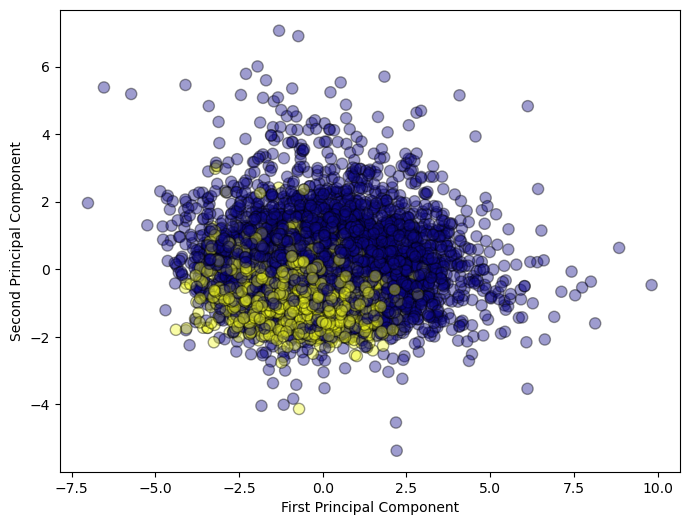

In [33]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

### Задание 7
Сделать вывод о структуре признаков данных

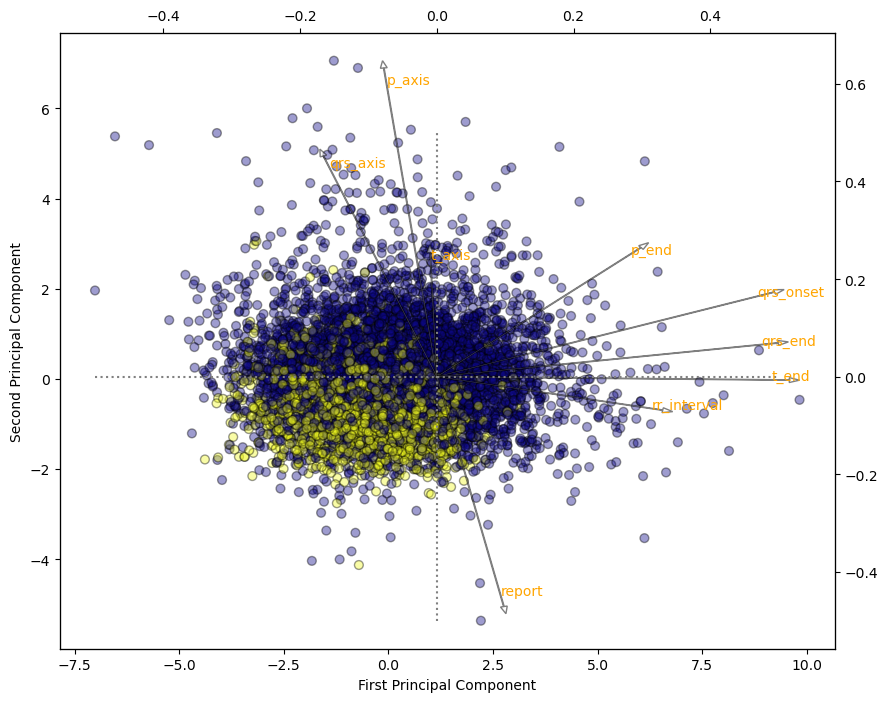

In [35]:
# put feature values into dataframe
components = pd.DataFrame(pca.components_.T, index=table_data_pca.columns, columns= ['PCA1','PCA2'])
# plot size
plt.figure(figsize=(10,8))
# main scatterplot
plt.scatter(x_pca[:,0], x_pca[:,1], c=full_df_filtered['Healthy_Status'],
            cmap='plasma', alpha=0.4, edgecolors='black', s=40);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
#plt.ylim(15,-15);
#plt.xlim(20,-20);

# individual feature values
ax2 = plt.twinx().twiny();
#ax2.set_ylim(-0.5,0.5);
#ax2.set_xlim(-0.5,0.5);

# reference lines
ax2.hlines(0,-0.5,0.5, linestyles='dotted', colors='grey')
ax2.vlines(0,-0.5,0.5, linestyles='dotted', colors='grey')

# offset for labels
offset = 0.95
# arrow & text
for a, i in enumerate(components.index):
  ax2.arrow(0, 0, components['PCA1'][a], -components['PCA2'][a], alpha=0.5, facecolor='white', head_width=.01)
  ax2.annotate(i, (components['PCA1'][a]*offset, -components['PCA2'][a]*offset), color='orange')

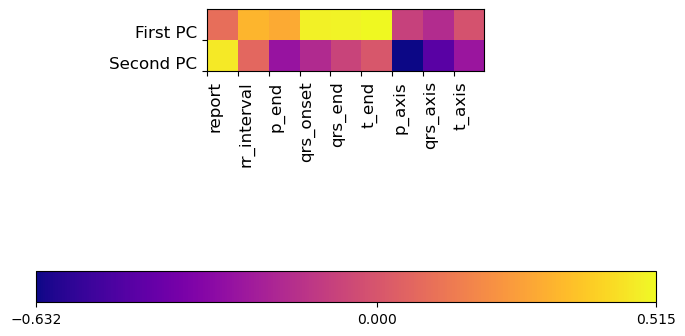

In [36]:
fig = plt.figure(figsize=(8, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
feature_names = list(table_data_pca.columns)
plt.gca().set_xticks(np.arange(-.5, len(feature_names)-1));
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left',fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom',fontsize=12);
plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0,
                                              pca.components_.max()],pad=0.65);

Text(0, 0.5, 'Second Principal Component')

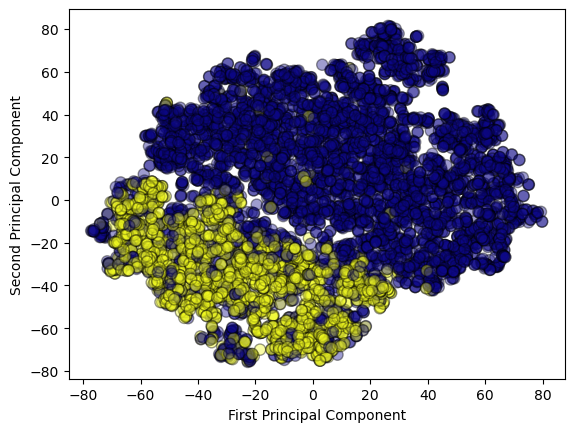

In [37]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
scaled_data_tsne = tsne.fit_transform(scaled_data)
plt.scatter(scaled_data_tsne[:,0], scaled_data_tsne[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [38]:
from sklearn import manifold
from time import time

Time code evaluation for perplexity=1 in 6 sec
Time code evaluation for perplexity=5 in 6.1 sec
Time code evaluation for perplexity=10 in 6.8 sec
Time code evaluation for perplexity=15 in 7.2 sec
Time code evaluation for perplexity=20 in 7.7 sec
Time code evaluation for perplexity=30 in 8.8 sec
Time code evaluation for perplexity=40 in 9.8 sec
Time code evaluation for perplexity=50 in 11 sec
Time code evaluation for perplexity=100 in 13 sec


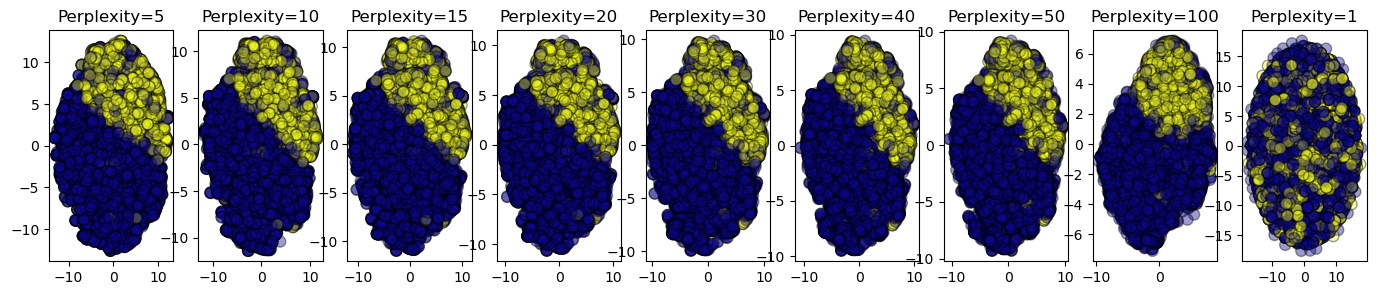

In [39]:
n_components = 2
perplexities = [1, 5, 10, 15, 20, 30, 40, 50, 100]

(fig, subplots) = plt.subplots(1, len(perplexities), figsize=(17, 3))

for i, perplexity in enumerate(perplexities):
    ax = subplots[i-1]

    t0 = time()
    tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        random_state=0,
        perplexity=perplexity,
        n_iter=300,
        )

    scaled_data_tsne = tsne.fit_transform(scaled_data)
    t1 = time()

    print("Time code evaluation for perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(scaled_data_tsne[:,0], scaled_data_tsne[:,1],
               c=full_df_filtered['Healthy_Status'],
               cmap='plasma',
               alpha=0.4,
               edgecolors='black',
               s=65
               );
    ax.axis("tight")

Методы PCA и TSNE демонстрируют разделение классов, визуализация показывает, что на начальных значениях perplexity результаты примерно одинаковы.

### Задание 8

In [42]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [43]:
table_data.columns

Index(['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end',
       'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status'],
      dtype='object')

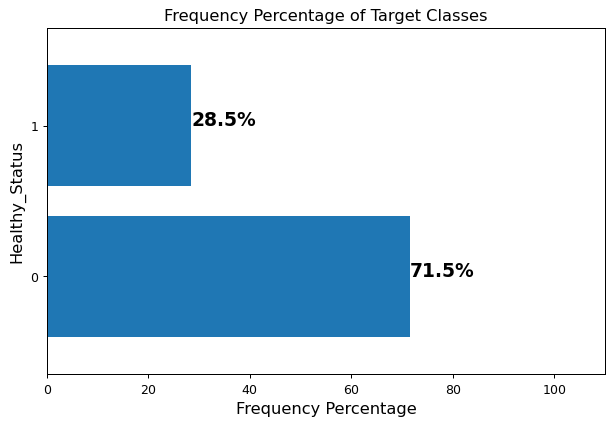

In [44]:
clf_index = 9
plt.figure(figsize=(35,20), dpi=90)
table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

labels = table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=13)
plt.ylabel(table_data.columns[clf_index], fontsize=13)
plt.title('Frequency Percentage of Target Classes', fontsize=13)
plt.show()

Виден дисбаланс классов, избавимся от него с помощью метода SMOTE

In [46]:
from imblearn.over_sampling import SMOTE

In [47]:
target_column = 'Healthy_Status'

smote = SMOTE(random_state=0)
X_initial = table_data.drop(target_column, axis=1)
y_initial = table_data[target_column]

X, y = smote.fit_resample(X_initial, y_initial)

df = pd.DataFrame(X, columns=X_initial.columns)
df[target_column] = y

df[target_column].value_counts()

Healthy_Status
0    5039
1    5039
Name: count, dtype: int64

In [48]:
X = df.drop(df.columns[[clf_index]], axis=1).iloc[:,:]
y = pd.Series(LabelEncoder().fit_transform(df.iloc[:, clf_index]))

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=0, stratify=y.values)

Возьмем за базовую отметку результаты модели наивного гауссовского байесовского алгоритма

In [51]:
сlassifier = GaussianNB()
сlassifier.fit(X_train, y_train)

GaussianNB()

In [52]:
y_train__pred = сlassifier.predict(X_train)
y_test__pred = сlassifier.predict(X_test)

In [53]:
(
    f'Accuracy train data {accuracy_score(y_train, y_train__pred)}',
    f'Accuracy test data {accuracy_score(y_test, y_test__pred)}'
)

('Accuracy train data 0.9043096115679047',
 'Accuracy test data 0.9113756613756614')

In [54]:
(
    f'F1 score train data {f1_score(y_train, y_train__pred)}',
    f'F1 score test data {f1_score(y_test, y_test__pred)}'
)

('F1 score train data 0.9093838099073701',
 'F1 score test data 0.9157232704402516')

              precision    recall  f1-score   support

        True       0.96      0.86      0.91      1512
       False       0.87      0.96      0.92      1512

    accuracy                           0.91      3024
   macro avg       0.92      0.91      0.91      3024
weighted avg       0.92      0.91      0.91      3024



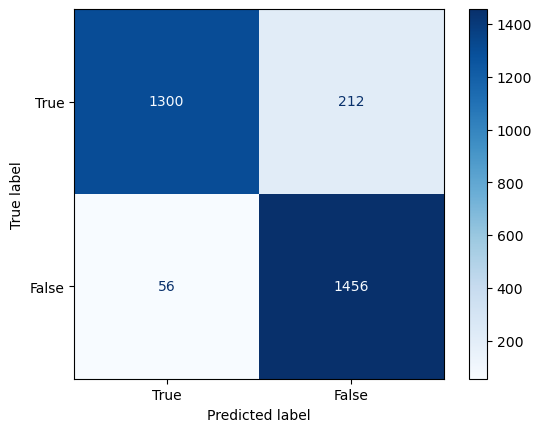

In [55]:
target_names = ['True', 'False']
labels_names = [0,1]
print(classification_report(y_test, y_test__pred, labels=labels_names, target_names=target_names))

cm = confusion_matrix(y_test, y_test__pred, labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

# LAMA

In [57]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [58]:
autoML_df = df[['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()

In [59]:
train_data, test_data = train_test_split(autoML_df, test_size=0.2, stratify=autoML_df['Healthy_Status'], random_state=42)

In [60]:
automl = TabularAutoML(
    task=Task('binary'),
    timeout=100,
    cpu_limit=4,
    reader_params={'n_jobs': 4, 'cv': 3, 'random_state': 42},
)

In [61]:
predictions = automl.fit_predict(train_data, roles={'target': 'Healthy_Status'}, verbose=0)

In [62]:
test_predictions = automl.predict(test_data).data

In [63]:
for i in range(len(test_predictions)):
    if test_predictions[i] > 0.5:
        test_predictions[i] = 1
    else:
        test_predictions[i] = 0

In [64]:
predictions_data = predictions.data
for i in range(len(predictions_data)):
    if predictions_data[i] > 0.5:
        predictions_data[i] = 1
    else:
        predictions_data[i] = 0

In [65]:
(
    f'Accuracy train data {accuracy_score(train_data["Healthy_Status"], predictions_data)}',
    f'Accuracy test data {accuracy_score(test_data["Healthy_Status"], test_predictions)}'
)

('Accuracy train data 0.9844951624906971',
 'Accuracy test data 0.9826388888888888')

In [66]:
(
    f'F1 score train data {f1_score(train_data["Healthy_Status"], predictions_data)}',
    f'F1 score test data {f1_score(test_data["Healthy_Status"], test_predictions)}'
)

('F1 score train data 0.9844662607182801',
 'F1 score test data 0.9825610363726955')

              precision    recall  f1-score   support

        True       0.98      0.99      0.98      1008
       False       0.99      0.98      0.98      1008

    accuracy                           0.98      2016
   macro avg       0.98      0.98      0.98      2016
weighted avg       0.98      0.98      0.98      2016



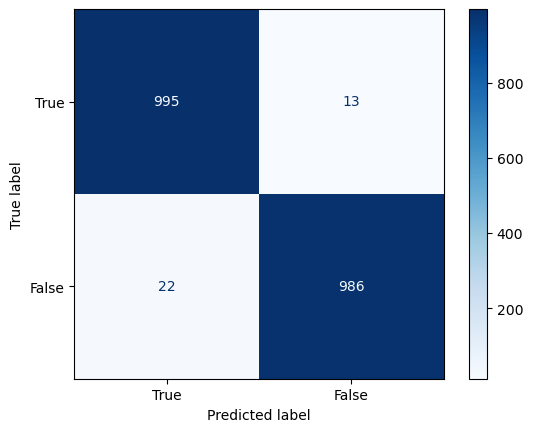

In [67]:
target_names = ['True', 'False']
labels_names = [0, 1]
print(classification_report(test_data['Healthy_Status'], test_predictions, labels=labels_names, target_names=target_names))

cm = confusion_matrix(test_data['Healthy_Status'], test_predictions, labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [68]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 1.00000 * (3 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


In [69]:
algo = automl.levels[0][0].ml_algos[0]
model = algo.models[0]
print(f'Алгоритм - {type(algo).__name__}\nМодель - {type(model).__name__}\n')

Алгоритм - BoostLGBM
Модель - Booster



In [70]:
with open(f'./lightautoml_electrocardiogram_m2_model.pkl', 'wb') as f:
    pickle.dump(automl, f)

In [71]:
import subprocess
from threading import Thread

def start_mlflow():
    subprocess.run(["mlflow", "ui", "--host", "0.0.0.0", "--port", "5000"])

Thread(target=start_mlflow, daemon=True).start()

In [72]:
mlflow.set_tracking_uri(uri='http://localhost:5000')
mlflow.set_experiment('Task 2')

<Experiment: artifact_location='mlflow-artifacts:/815572667296263577', creation_time=1744220956347, experiment_id='815572667296263577', last_update_time=1744220956347, lifecycle_stage='active', name='Task 2', tags={}>

In [116]:
with mlflow.start_run(run_name='LAMA'):
    mlflow.log_params(
        {
            'n_jobs': 4, 
            'cv': 3, 
            'random_state': 42,
            'timeout': 100,
            'cpu_limit': 4,
            'algoritm': algo,
            'model': model
        }
    )
    mlflow.log_metrics(
        {
            'Accuracy train data': accuracy_score(train_data['Healthy_Status'], predictions_data),
            'Accuracy test data': accuracy_score(test_data["Healthy_Status"], test_predictions),
            'F1 score train data': f1_score(train_data["Healthy_Status"], predictions_data),
            'F1 score test data': f1_score(test_data["Healthy_Status"], test_predictions),
        }
    )
    mlflow.log_artifact('./lightautoml_electrocardiogram_m2_model.pkl')
    
    model_info = mlflow.sklearn.log_model(
        sk_model=automl,
        artifact_path='lama_model',
        signature=infer_signature(train_data, predictions_data),
        input_example=train_data,
    )

🏃 View run LAMA at: http://localhost:5000/#/experiments/815572667296263577/runs/0aeaf39a089c42f287b4cca80f574c5b
🧪 View experiment at: http://localhost:5000/#/experiments/815572667296263577


# FEDOT

In [123]:
from fedot.api.main import Fedot

In [125]:
fedot_model = Fedot(problem='classification', timeout=3)

In [127]:
obtained_pipeline = fedot_model.fit(features=X_train, target=y_train)

2025-04-09 21:00:33,583 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-04-09 21:00:40,345 - ApiComposer - Initial pipeline was fitted in 5.1 sec.
2025-04-09 21:00:40,347 - ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 25.3 sec.
2025-04-09 21:00:40,349 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2025-04-09 21:00:40,388 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 3 min. Set of candidate models: ['bernb', 'catboost', 'dt', 'fast_ica', 'isolation_forest_class', 'knn', 'lgbm', 'logit', 'mlp', 'normalization', 'pca', 'poly_features', 'qda', 'resample', 'rf', 'scaling', 'xgboost'].
2025-04-09 21:00:40,594 - ApiComposer - Pipeline composition started.


Generations:   0%|                                                                          | 0/10000 [00:00<?, ?gen/s]

2025-04-09 21:01:05,017 - MultiprocessingDispatcher - 6 individuals out of 6 in previous population were evaluated successfully.
2025-04-09 21:02:05,359 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2025-04-09 21:02:05,450 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                          | 0/10000 [01:24<?, ?gen/s]


2025-04-09 21:02:05,714 - ApiComposer - Hyperparameters tuning started with 2 min. timeout
2025-04-09 21:02:11,298 - SimultaneousTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [lgbm]}
lgbm - {'boosting_type': 'gbdt', 'max_depth': -1, 'bagging_fraction': 0.85, 'extra_trees': False, 'enable_categorical': True, 'use_eval_set': True, 'early_stopping_rounds': 30, 'n_jobs': 1, 'verbose': -1} 
Initial metric: [0.996]
  0%|                                       | 15/100000 [01:25<158:42:01,  5.71s/trial, best loss: -0.9962801895295896]
2025-04-09 21:03:44,745 - SimultaneousTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [lgbm]}
lgbm - {'boosting_type': 'gbdt', 'max_depth': -1, 'bagging_fraction': 0.85, 'extra_trees': False, 'enable_categorical': True, 'use_eval_set': True, 'early_stopping_rounds': 30, 'n_jobs': 1, 'verbose': -1}
2025-04-09 21:03:44,748 - SimultaneousTuner - Final metric: 0.996
2025-04-09 21:03:44,751 - ApiComposer - Hyperparameters tuning finished
2025-04-09

In [128]:
y_train__predict = fedot_model.predict(X_train)
y_test__predict = fedot_model.predict(X_test)

In [129]:
(
    f'Accuracy train data {accuracy_score(y_train, y_train__predict)}',
    f'Accuracy test data {accuracy_score(y_test, y_test__predict)}'
)

('Accuracy train data 0.9965976750779699',
 'Accuracy test data 0.9798280423280423')

In [130]:
(
    f'F1 score train data {f1_score(y_train, y_train__predict)}',
    f'F1 score test data {f1_score(y_test, y_test__predict)}'
)

('F1 score train data 0.9966034531559581',
 'F1 score test data 0.9798347107438017')

              precision    recall  f1-score   support

        True       0.98      0.98      0.98      1512
       False       0.98      0.98      0.98      1512

    accuracy                           0.98      3024
   macro avg       0.98      0.98      0.98      3024
weighted avg       0.98      0.98      0.98      3024



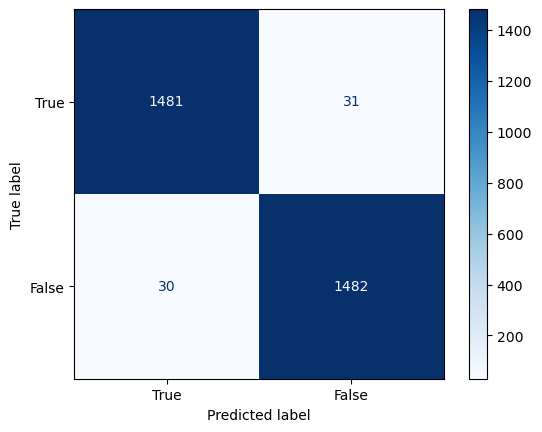

In [131]:
target_names = ['True', 'False']
labels_names = [0,1]
print(classification_report(y_test, y_test__predict, labels=labels_names, target_names=target_names))

cm = confusion_matrix(y_test, y_test__predict, labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [132]:
fedot_model.current_pipeline

{'depth': 1, 'length': 1, 'nodes': [lgbm]}

In [133]:
with open(f'./fedot_model_task2.pkl', 'wb') as f:
    pickle.dump(fedot_model, f)

In [134]:
with mlflow.start_run(run_name='FEDOT'):
    mlflow.log_params(
        {
            'problem':'classification',
            'timeout': 3,
        }
    )
    mlflow.log_metrics(
        {
            'Accuracy train data': accuracy_score(y_train, y_train__predict),
            'Accuracy test data': accuracy_score(y_test, y_test__predict),
            'F1 score train data': f1_score(y_train, y_train__predict),
            'F1 score test data': f1_score(y_test, y_test__predict)
        }
    )
    mlflow.log_artifact('./fedot_model_task2.pkl')
    
    model_info = mlflow.sklearn.log_model(
        sk_model=fedot_model,
        artifact_path='model_fedot',
        signature=infer_signature(X_train, y_train__predict),
        input_example=X_train,
    )

🏃 View run FEDOT at: http://localhost:5000/#/experiments/815572667296263577/runs/51d21c7e45354e8b8105c129a1c6f85c
🧪 View experiment at: http://localhost:5000/#/experiments/815572667296263577


# TPOT

In [144]:
from tpot import TPOTClassifier

In [146]:
X = df.iloc[:, df.columns != 'Healthy_Status'].values
y = df.iloc[:, df.columns == 'Healthy_Status'].values.reshape(-1)

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=200)

In [150]:
tpot = TPOTClassifier(generations=5, population_size=50, random_state=42, verbosity=2, max_time_mins=5)

In [152]:
tpot.fit(X_train, y_train)

Version 0.12.2 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


Optimization Progress:   0%|          | 0/50 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9730642218435696

5.04 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBClassifier(RandomForestClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.7500000000000001, min_samples_leaf=2, min_samples_split=10, n_estimators=100), learning_rate=0.1, max_depth=9, min_child_weight=20, n_estimators=100, n_jobs=1, subsample=0.7500000000000001, verbosity=0)


TPOTClassifier(generations=5, max_time_mins=5, population_size=50,
               random_state=42, verbosity=2)

In [153]:
y_train__predict = tpot.predict(X_train)
y_test__predict = tpot.predict(X_test)

In [154]:
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    print(f'{idx}. {transform}')

1. StackingEstimator(estimator=RandomForestClassifier(bootstrap=False,
                                                   criterion='entropy',
                                                   max_features=0.7500000000000001,
                                                   min_samples_leaf=2,
                                                   min_samples_split=10,
                                                   random_state=42))
2. XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
         

In [155]:
(
    f'Accuracy train data {accuracy_score(y_train, y_train__predict)}',
    f'Accuracy test data {accuracy_score(y_test, y_test__predict)}'
)

('Accuracy train data 0.9988658916926566',
 'Accuracy test data 0.9748677248677249')

In [156]:
(
    f'F1 score train data {f1_score(y_train, y_train__predict)}',
    f'F1 score test data {f1_score(y_test, y_test__predict)}'
)

('F1 score train data 0.9988655700510494',
 'F1 score test data 0.9751146037982973')

              precision    recall  f1-score   support

        True       0.98      0.97      0.97      1511
       False       0.97      0.98      0.98      1513

    accuracy                           0.97      3024
   macro avg       0.98      0.97      0.97      3024
weighted avg       0.98      0.97      0.97      3024



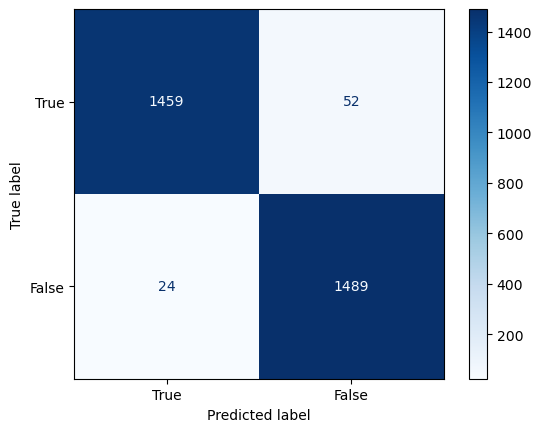

In [157]:
target_names = ['True', 'False']
labels_names = [0,1]
print(classification_report(y_test, y_test__predict, labels=labels_names, target_names=target_names))

cm = confusion_matrix(y_test, y_test__predict, labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [158]:
with open('./tpot_model_task2.pkl', 'wb') as f:
    pickle.dump(tpot.fitted_pipeline_, f)

In [159]:
with mlflow.start_run(run_name='TPOT'):
    mlflow.log_params(
        {
            'generations': 5, 
            'population_size': 50, 
            'random_state': 42, 
            'verbosity': 2
        }
    )
    mlflow.log_metrics(
        {
            'Accuracy train data': accuracy_score(y_train, y_train__predict),
            'Accuracy test data': accuracy_score(y_test, y_test__predict),
            'F1 score train data': f1_score(y_train, y_train__predict),
            'F1 score test data': f1_score(y_test, y_test__predict)
        }
    )
    mlflow.log_artifact('./tpot_model_task2.pkl')
    
    model_info = mlflow.sklearn.log_model(
        sk_model=tpot.fitted_pipeline_,
        artifact_path='tpot_model',
        signature=infer_signature(X_train, y_train__predict),
        input_example=X_train,
    )

🏃 View run TPOT at: http://localhost:5000/#/experiments/815572667296263577/runs/968b7e2420a34bd0896fd88ec2eb21e2
🧪 View experiment at: http://localhost:5000/#/experiments/815572667296263577
